In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy

# Q1 Image Downsampling

In [2]:
original_img = Image.open("images/city.png")
img = np.array(original_img).astype(np.float64)
img.shape

(1000, 1500)

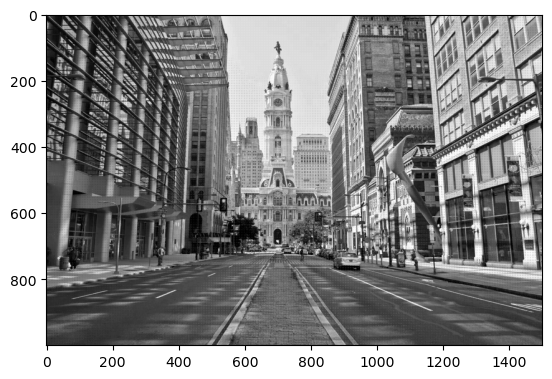

In [3]:
plt.imshow(img, cmap = "gray")
# plt.axis("off")

### 1.a) Downsample and Observe

In [4]:
# Required Function for the question
def downSample(image, scale=1):
    scaled_img = np.zeros(np.array(image.shape) // scale)
    for i in range(scaled_img.shape[0]):
        for j in range(scaled_img.shape[1]):
            x, y = i * scale, j * scale
            scaled_img[i, j] = image[x, y]
    return scaled_img

In [5]:
downSample_factors = [2, 4, 5]

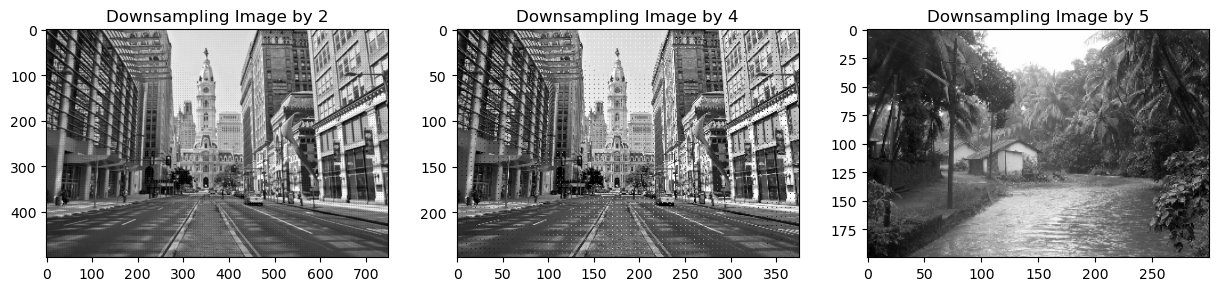

In [6]:
downSample_imgs = []
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
for i in range(len(downSample_factors)):
    scale = downSample_factors[i]
    res = downSample(img, scale)
    downSample_imgs.append(res)

    axes[i].imshow(res, cmap='gray')
    axes[i].set_title(f"""Downsampling Image by {scale}""")


##### Every 5th pixel is the pixel of an another image
##### Further, If you use Bilinear Interpolation, still you'll get the aliasing as Bilinear Interpolation is not that good of a low pass filter, Aliasing will be reduced a little but it will still be there

## 1.b) Anti-Aliasing (LP) Filter before Downsampling

In [7]:
def gaussianKernel(size = 5, sigma = 2):
    kernel = np.zeros((size, size), dtype=np.float32)

    for i in range(size):
        for j in range(size):
            # finding the centered cords for gaussian calculation
            x = i - ((size - 1) // 2)
            y = j - ((size - 1) // 2)

            kernel[i,j] = np.exp(-((x**2) + (y**2)) / (2 * (sigma ** 2)))
    
    kernel /= np.sum(kernel)
    return kernel
    

In [8]:
def imageBlur(image, win = 5, std = 2):
    kernel = gaussianKernel(win, std)
    img_blur = scipy.ndimage.convolve(image, kernel)
    return img_blur

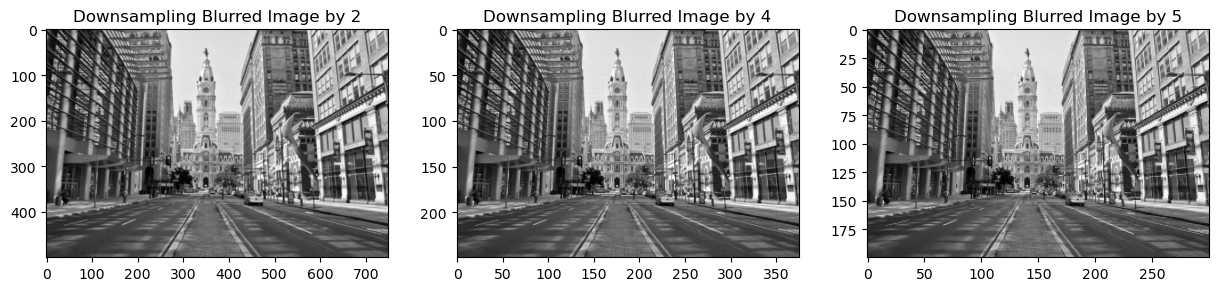

In [9]:
downSample_imgs_AA = []
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
for i in range(len(downSample_factors)):
    scale = downSample_factors[i]
    res = downSample(imageBlur(img, 5, 2), scale)
    downSample_imgs_AA.append(res)

    axes[i].imshow(res, cmap='gray')
    axes[i].set_title(f"""Downsampling Blurred Image by {scale}""")


In [10]:
def downSampleUsingLib(image, scale):
    width, height = image.size
    height, width = height // scale, width // scale
    res_img = image.resize((width, height))
    return np.array(res_img)

def MSE(img1, img2):
    if img1.shape == img2.shape:
        err = np.sum((img1 - img2) ** 2) / (img1.size)
        return err
    print("Image Dimension does not match")
    return None
    

MSE of the downsample image by 2 for a clean image is: 89.45114666666667 and for a Blurred Image is: 38.795011557671735
MSE of the downsample image by 4 for a clean image is: 206.23618133333332 and for a Blurred Image is: 66.98602990458973
MSE of the downsample image by 5 for a clean image is: 1494.0309333333332 and for a Blurred Image is: 94.06856170321649


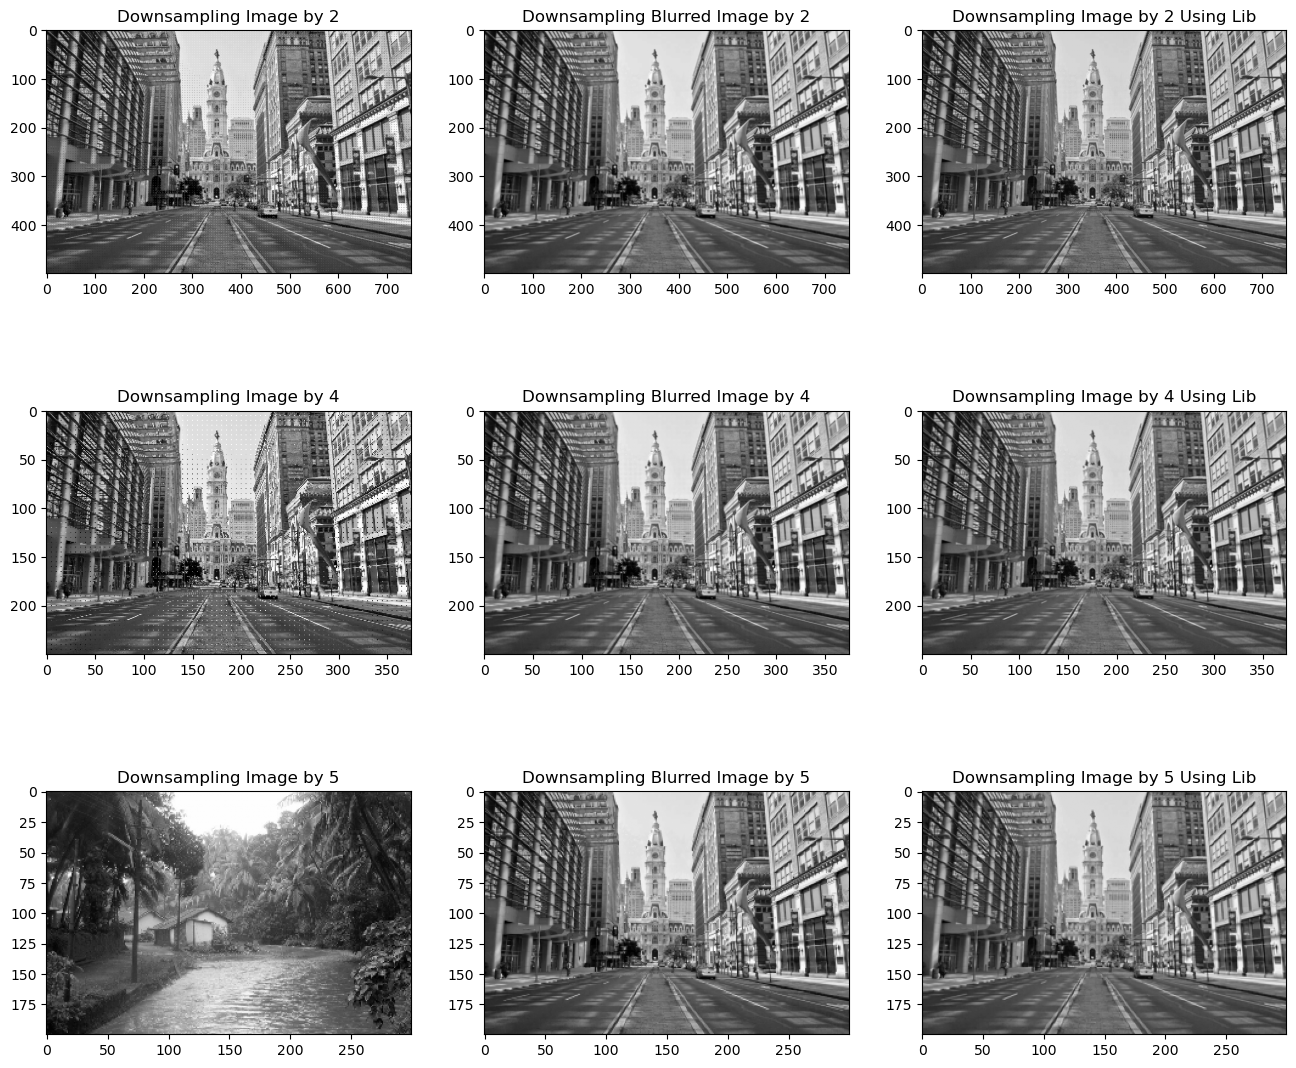

In [11]:
# Comparing with the Library
fig,axes = plt.subplots(nrows=3, ncols=3, figsize=(16,14))
for i in range(3):
    scale = downSample_factors[i]
    downSample_img_lib = downSampleUsingLib(original_img, scale)

    axes[i, 0].imshow(downSample_imgs[i], cmap='gray')
    axes[i, 0].set_title(f"""Downsampling Image by {scale}""")
    axes[i, 1].imshow(downSample_imgs_AA[i], cmap='gray')
    axes[i, 1].set_title(f"""Downsampling Blurred Image by {scale}""")
    axes[i, 2].imshow(downSample_img_lib, cmap='gray')
    axes[i, 2].set_title(f"""Downsampling Image by {scale} Using Lib""")

    print(f"""MSE of the downsample image by {scale} for a clean image is: {MSE(downSample_imgs[i], downSample_img_lib)} and for a Blurred Image is: {MSE(downSample_imgs_AA[i], downSample_img_lib)}""")

## 1.c) Find the required Kernel for N=5

In [12]:
windows = np.arange(3, 20, 2)
std_list = np.linspace(0, 4, 21)[1:]  # Removing the 0 Sigma Value
ref_img = downSampleUsingLib(original_img, 5).astype(np.float64)


In [13]:
windows, std_list

(array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
 array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
        2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]))

In [14]:
res_win = 0
res_std = 0
res_mse = float('inf')
res_img = ''
for win in windows:
    for std in std_list:
        kernel = gaussianKernel(win, std)
        img_blur = scipy.ndimage.convolve(img, kernel)
        res = downSample(img_blur, 5)
        mse = MSE(res, ref_img)
        if mse < res_mse:
            res_win = win
            res_std = std
            res_mse = mse
            res_img = res
print(f"""Optimal Window Size: {res_win}\nOptimal Sigma: {res_std}\nOptimal MSE: {res_mse}""")


Optimal Window Size: 11
Optimal Sigma: 2.8000000000000003
Optimal MSE: 73.01106870903419


In [15]:
mse = MSE(downSample_imgs_AA[2], ref_img)
print("MSE for the win 5x5 with sigma = 2: ", mse)
print(f"""MSE for the win {res_win} with sigma = {res_std:.2f}: {res_mse}""")

MSE for the win 5x5 with sigma = 2:  94.06856170321649
MSE for the win 11 with sigma = 2.80: 73.01106870903419


Text(0.5, 1.0, 'Downsampling Image by 5 Using Lib')

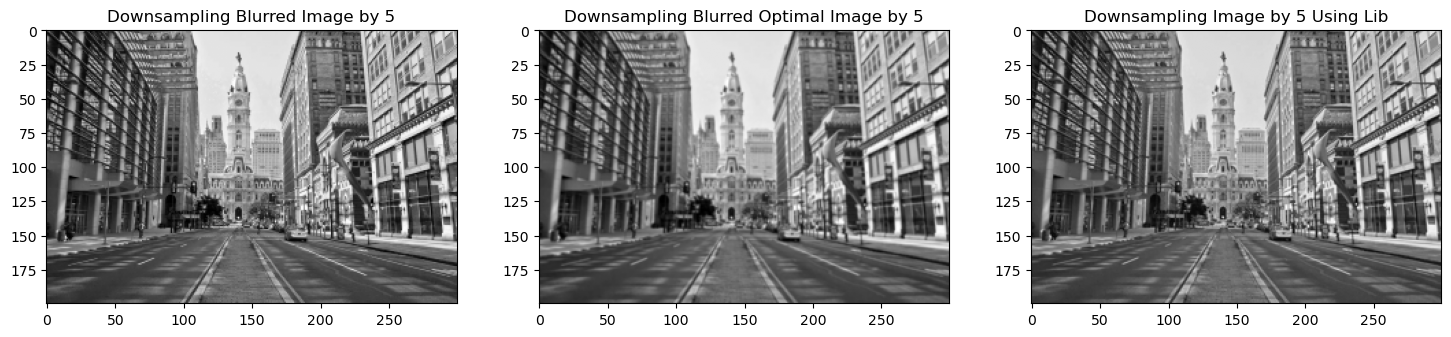

In [16]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(18,10))
axes[0].imshow(downSample_imgs_AA[2], cmap='gray')
axes[0].set_title(f"""Downsampling Blurred Image by 5""")
axes[1].imshow(res_img, cmap='gray')
axes[1].set_title(f"""Downsampling Blurred Optimal Image by 5""")
axes[2].imshow(ref_img, cmap='gray')
axes[2].set_title(f"""Downsampling Image by 5 Using Lib""")

# Q2. Edge Detection

In [17]:
# To Find Threshold for Gradient Based Method
def betweenClassVar(image, t):
    histo, _ = np.histogram(image, bins=256, range=(0,256))
    
    histo_norm = histo / np.sum(histo)
    w0 = np.sum(histo_norm[:t+1])
    w1 = 1 - w0
    
    #error control divide by 0
    if w0 == 0 or w1 == 0:
        return float('-inf')
        
    imgMeanArr = np.arange(histo_norm.shape[0]) * histo_norm
    mean_0 = np.sum(imgMeanArr[:t+1]) / w0
    mean_1 = np.sum(imgMeanArr[t+1:]) / w1
    inter_var = w0 * w1 * ((mean_0 - mean_1) ** 2)
    return inter_var

def findThreshold(image):
    optimal_t, max_weighted_var = 0, float('-inf')
    for t in range(256):
        inter_var = betweenClassVar(image, t)
        if inter_var > max_weighted_var:
            max_weighted_var = inter_var
            optimal_t = t
    return optimal_t

def sobel(image):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Sy = Sx.T
    
    Gx = scipy.ndimage.convolve(image, Sx)
    Gy = scipy.ndimage.convolve(image, Sy)
    
    res = np.sqrt((Gx ** 2) + (Gy ** 2))

    #Threshold Determination (Otsu)
    res = np.clip(res, 0, 255)
    T = findThreshold(res)
    print("Optimal Threshold for Sobel: ", T)

    # Binarization of the Edge
    res_img = np.zeros(res.shape)
    res_img[res > T] = 255
    return res_img

In [18]:
def LOG(win = 5, std = 2):
    idx = np.arange(-(win // 2), (win // 2) + 1)
    i, j = np.meshgrid(idx, idx, indexing='ij')
    temp = ((i ** 2) + (j ** 2)) / (2 * (std ** 2))
    temp2 = 2 / (std ** 2)
    
    kernel = temp2 * (temp - 1) * (np.exp(-temp))
    return kernel

def LOGEdgeDetector(image, win = 5, std = 2):
    kernel = LOG(win, std)
    img_con = scipy.ndimage.convolve(image, kernel)
    
    # Zero Cross will be highlighted
    M, N = img_con.shape
    res_img = np.zeros((M, N), dtype=np.float32)
    for i in range(M):
        for j in range(N):
            up = img_con[max(0, i - 1), j]
            down = img_con[min(M - 1, i + 1), j]
            left = img_con[i, max(0, j - 1)]
            right = img_con[i, min(N - 1, j + 1)]

            if (up * down) < 0 or (left * right) < 0:
                res_img[i,j] = 255
    return res_img

Text(0.5, 1.0, 'LOG Kernel (13x13, 2)')

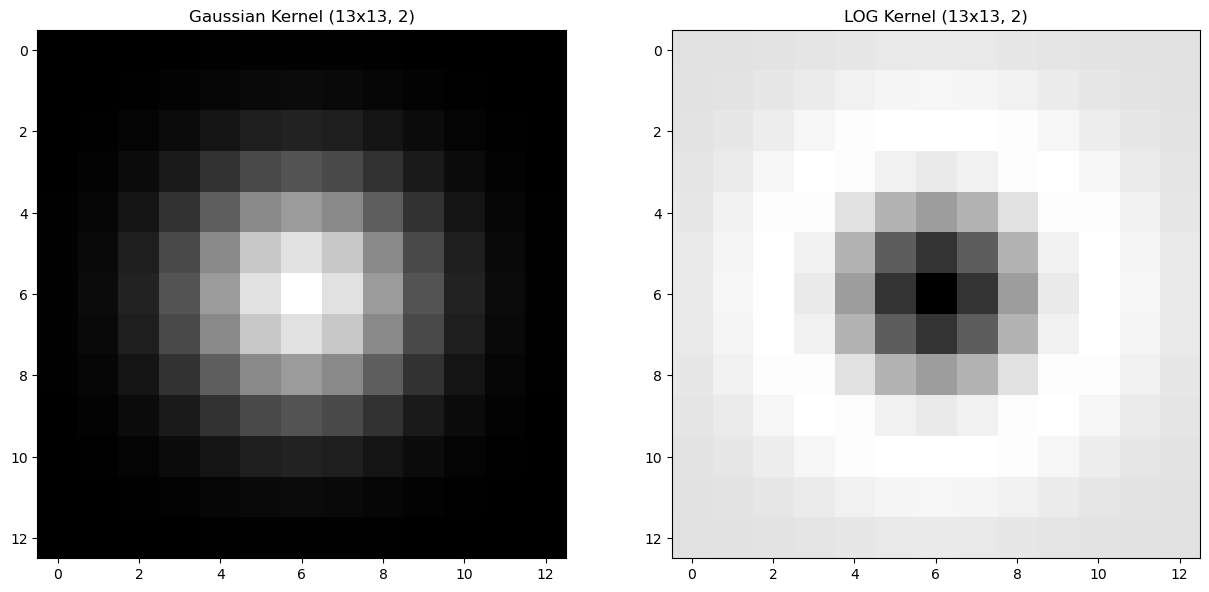

In [19]:
# Showing Gaussian and LOG
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15,12))
axes[0].imshow(gaussianKernel(13, 2), cmap='gray')
axes[0].set_title("Gaussian Kernel (13x13, 2)")
axes[1].imshow(LOG(13, 2), cmap='gray')
axes[1].set_title("LOG Kernel (13x13, 2)")

## 2.a) Detect Edges using Sobel and LOG

In [20]:
checkBoard = np.array(Image.open("images/Checkerboard.png")).astype(np.float64)
coins = np.array(Image.open("images/Coins.png")).astype(np.float64)
iisc = np.array(Image.open("images/MainBuilding.png")).astype(np.float64)
flower = np.array(Image.open("images/flowers.png")).astype(np.float64)

In [21]:
images = [checkBoard, coins, iisc, flower]
label = ['CheckBoard', 'Coins', 'IISc', 'Flowers']

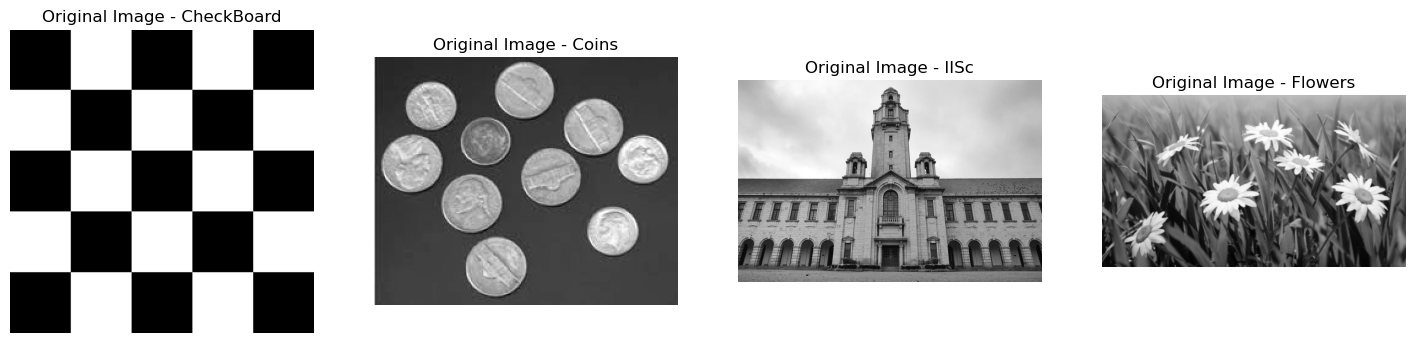

In [22]:
#Showing Input Images
fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(18,20))
for i in range(len(images)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"""Original Image - {label[i]}""")

Optimal Threshold for Sobel:  0
Optimal Threshold for Sobel:  113
Optimal Threshold for Sobel:  104
Optimal Threshold for Sobel:  116


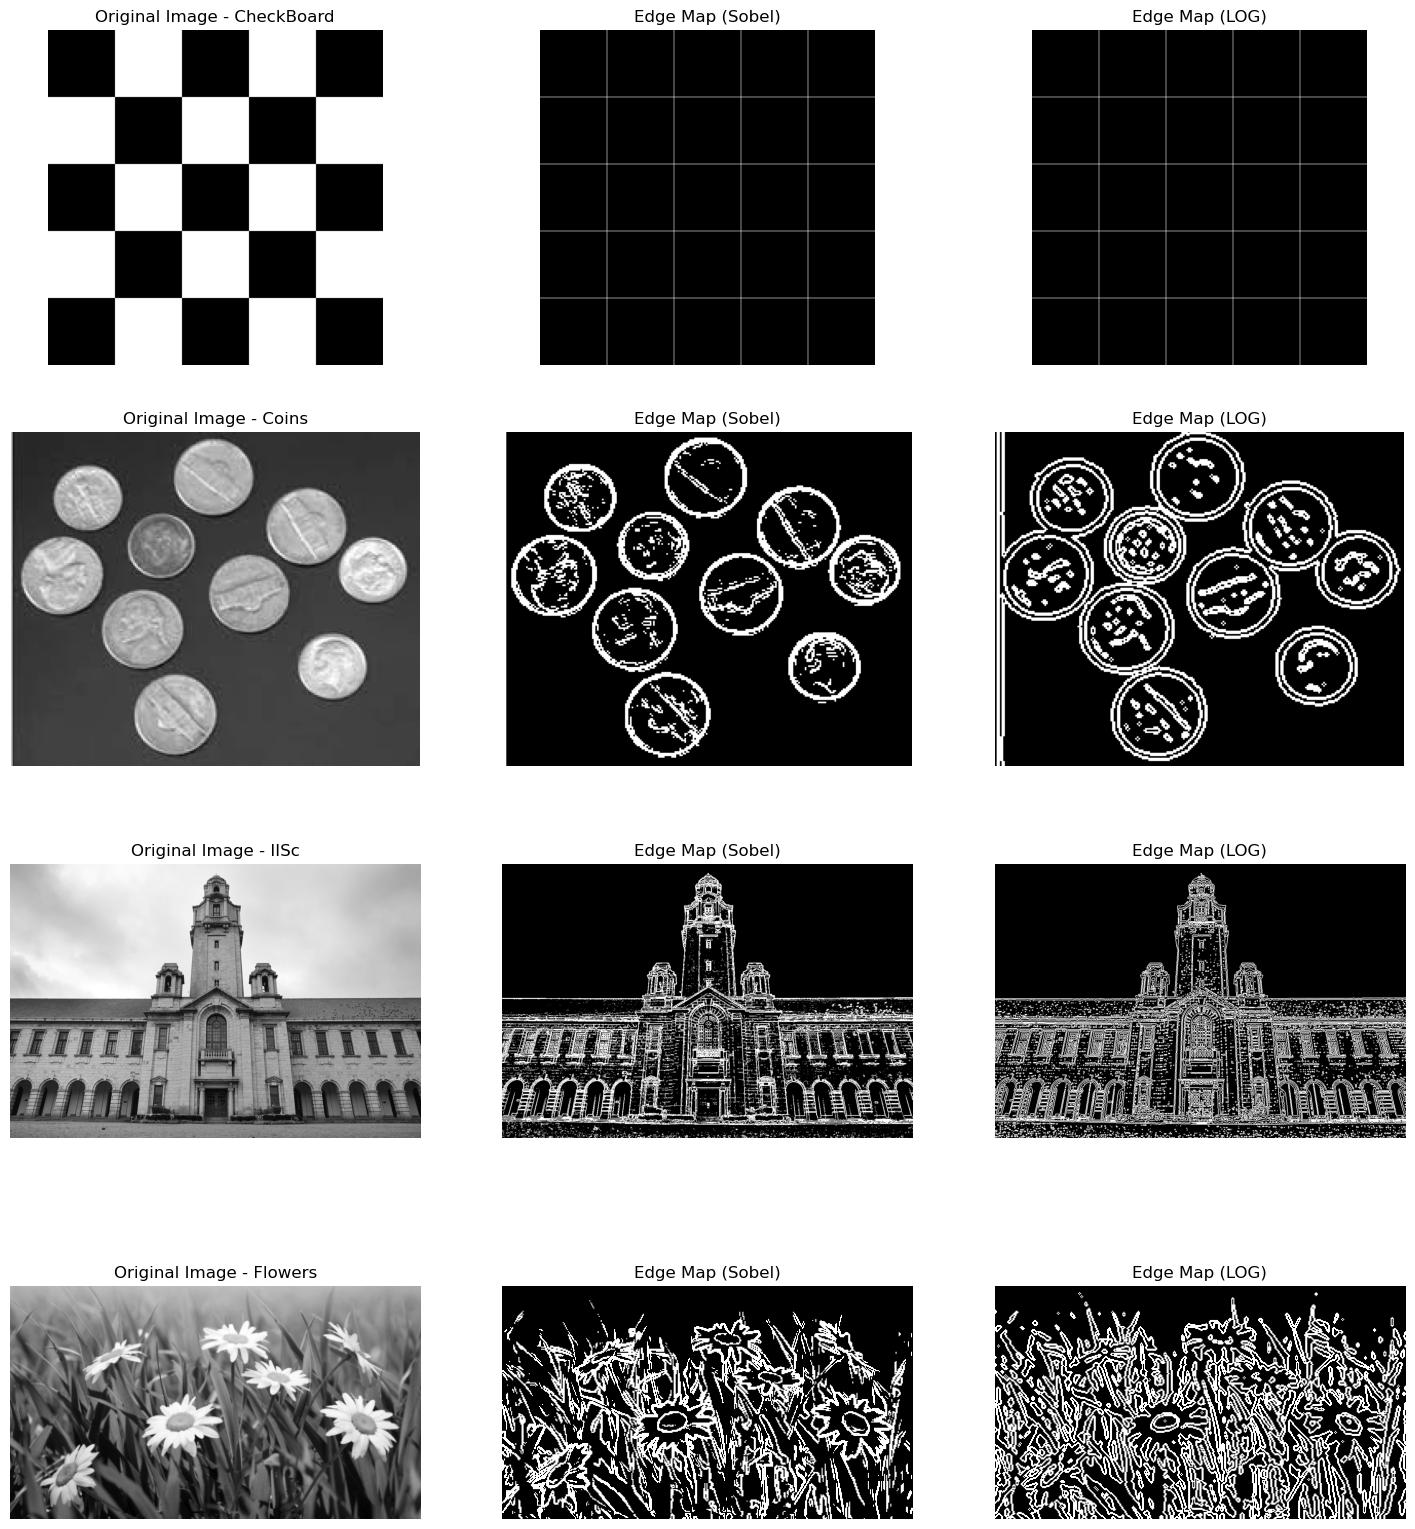

In [23]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(18,20))
for i in range(len(images)):
    axes[i, 0].imshow(images[i], cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"""Original Image - {label[i]}""")
    axes[i, 1].imshow(sobel(images[i]), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"""Edge Map (Sobel)""")
    axes[i, 2].imshow(LOGEdgeDetector(images[i], 9, 1.5), cmap='gray')
    axes[i, 2].axis("off")
    axes[i, 2].set_title(f"""Edge Map (LOG)""")


## 2.b) Edge Detection after Gaussian Smoothing after Adding Gaussian Noise

Optimal Threshold for Sobel:  127
Optimal Threshold for Sobel:  74
Optimal Threshold for Sobel:  55
Optimal Threshold for Sobel:  69


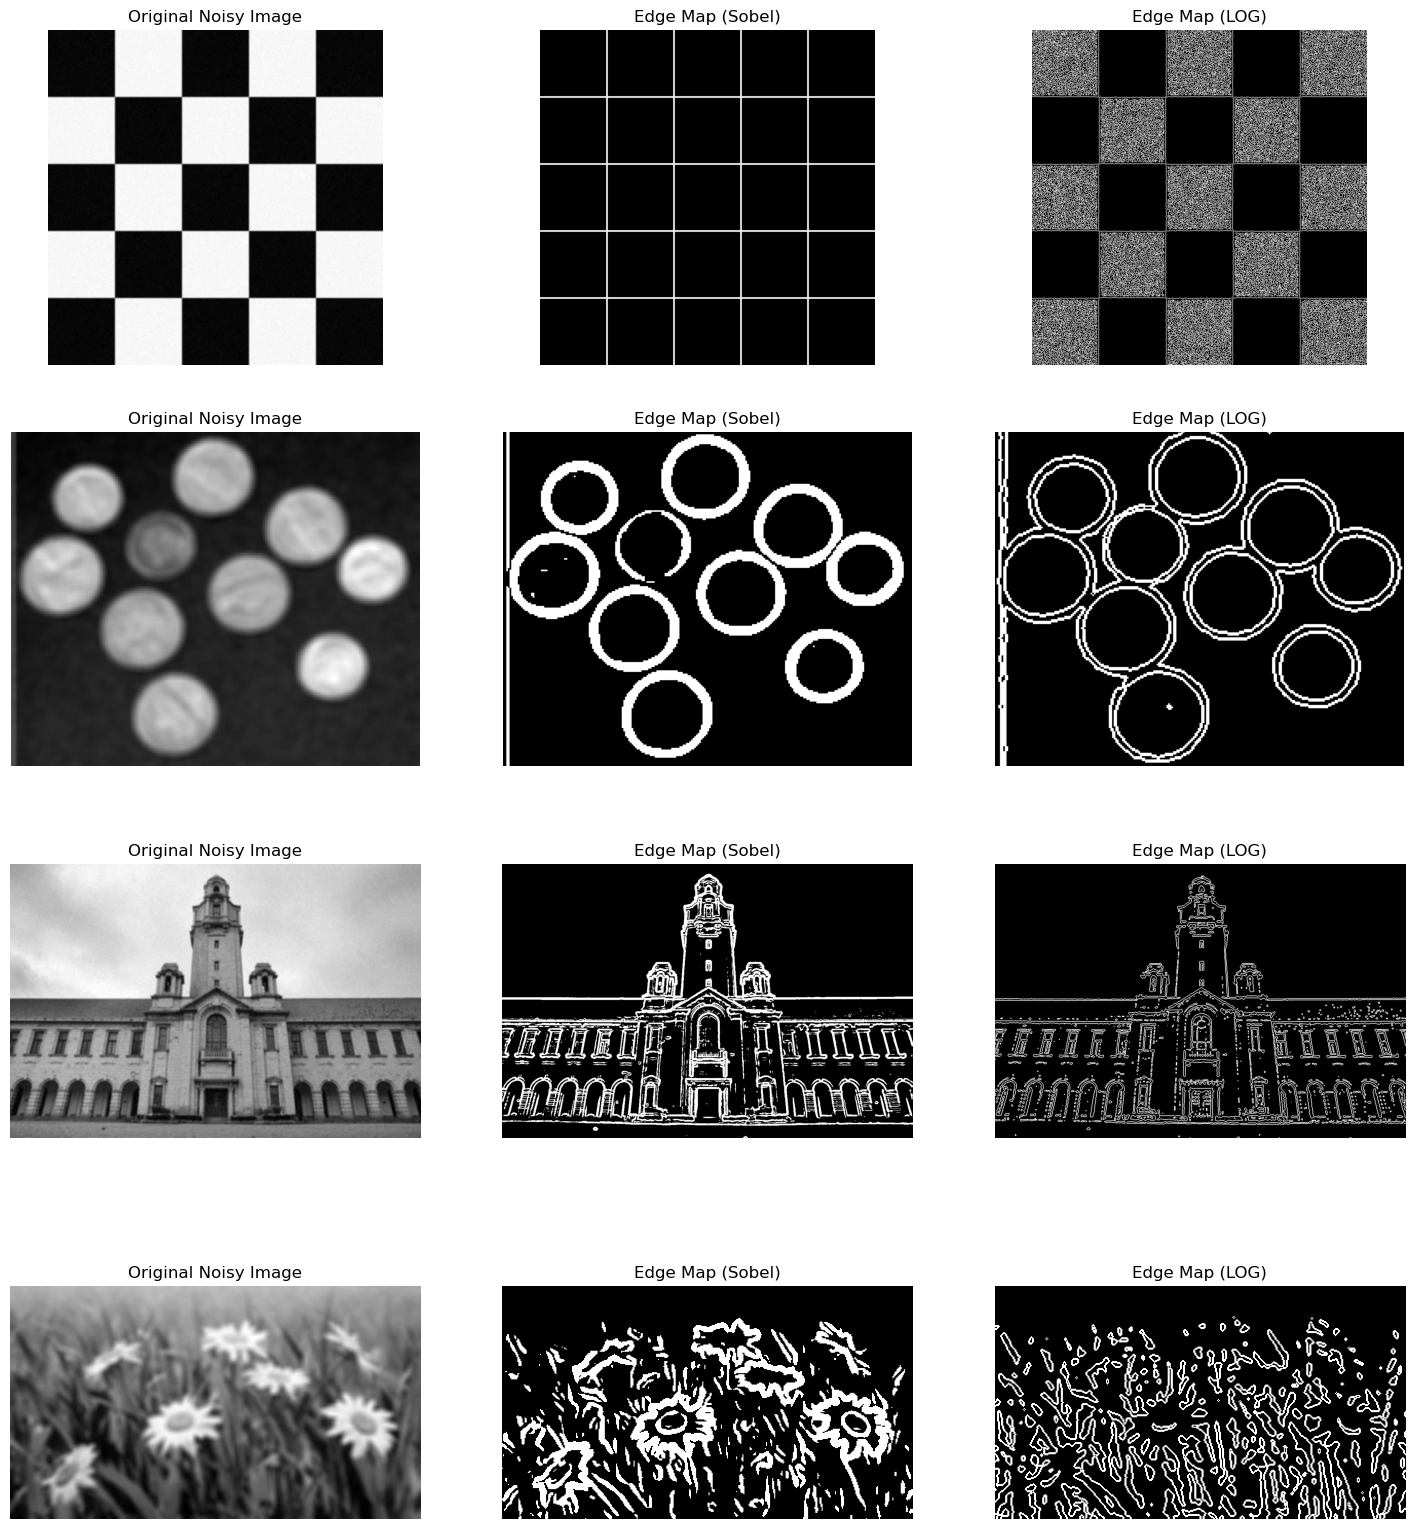

In [24]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
for i in range(len(images)):
    noise = np.random.normal(0, 12, images[i].shape)
    image = images[i] + noise
    
    image = imageBlur(image, 7, 3)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"""Original Noisy Image""")
    axes[i, 1].imshow(sobel(image), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"""Edge Map (Sobel)""")
    axes[i, 2].imshow(LOGEdgeDetector(image, 9, 1.5), cmap='gray')
    axes[i, 2].axis("off")
    axes[i, 2].set_title(f"""Edge Map (LOG)""")


## 2.c) Edge Detection after Gaussian Smoothing without Adding Noise

Optimal Threshold for Sobel:  128
Optimal Threshold for Sobel:  72
Optimal Threshold for Sobel:  52
Optimal Threshold for Sobel:  67


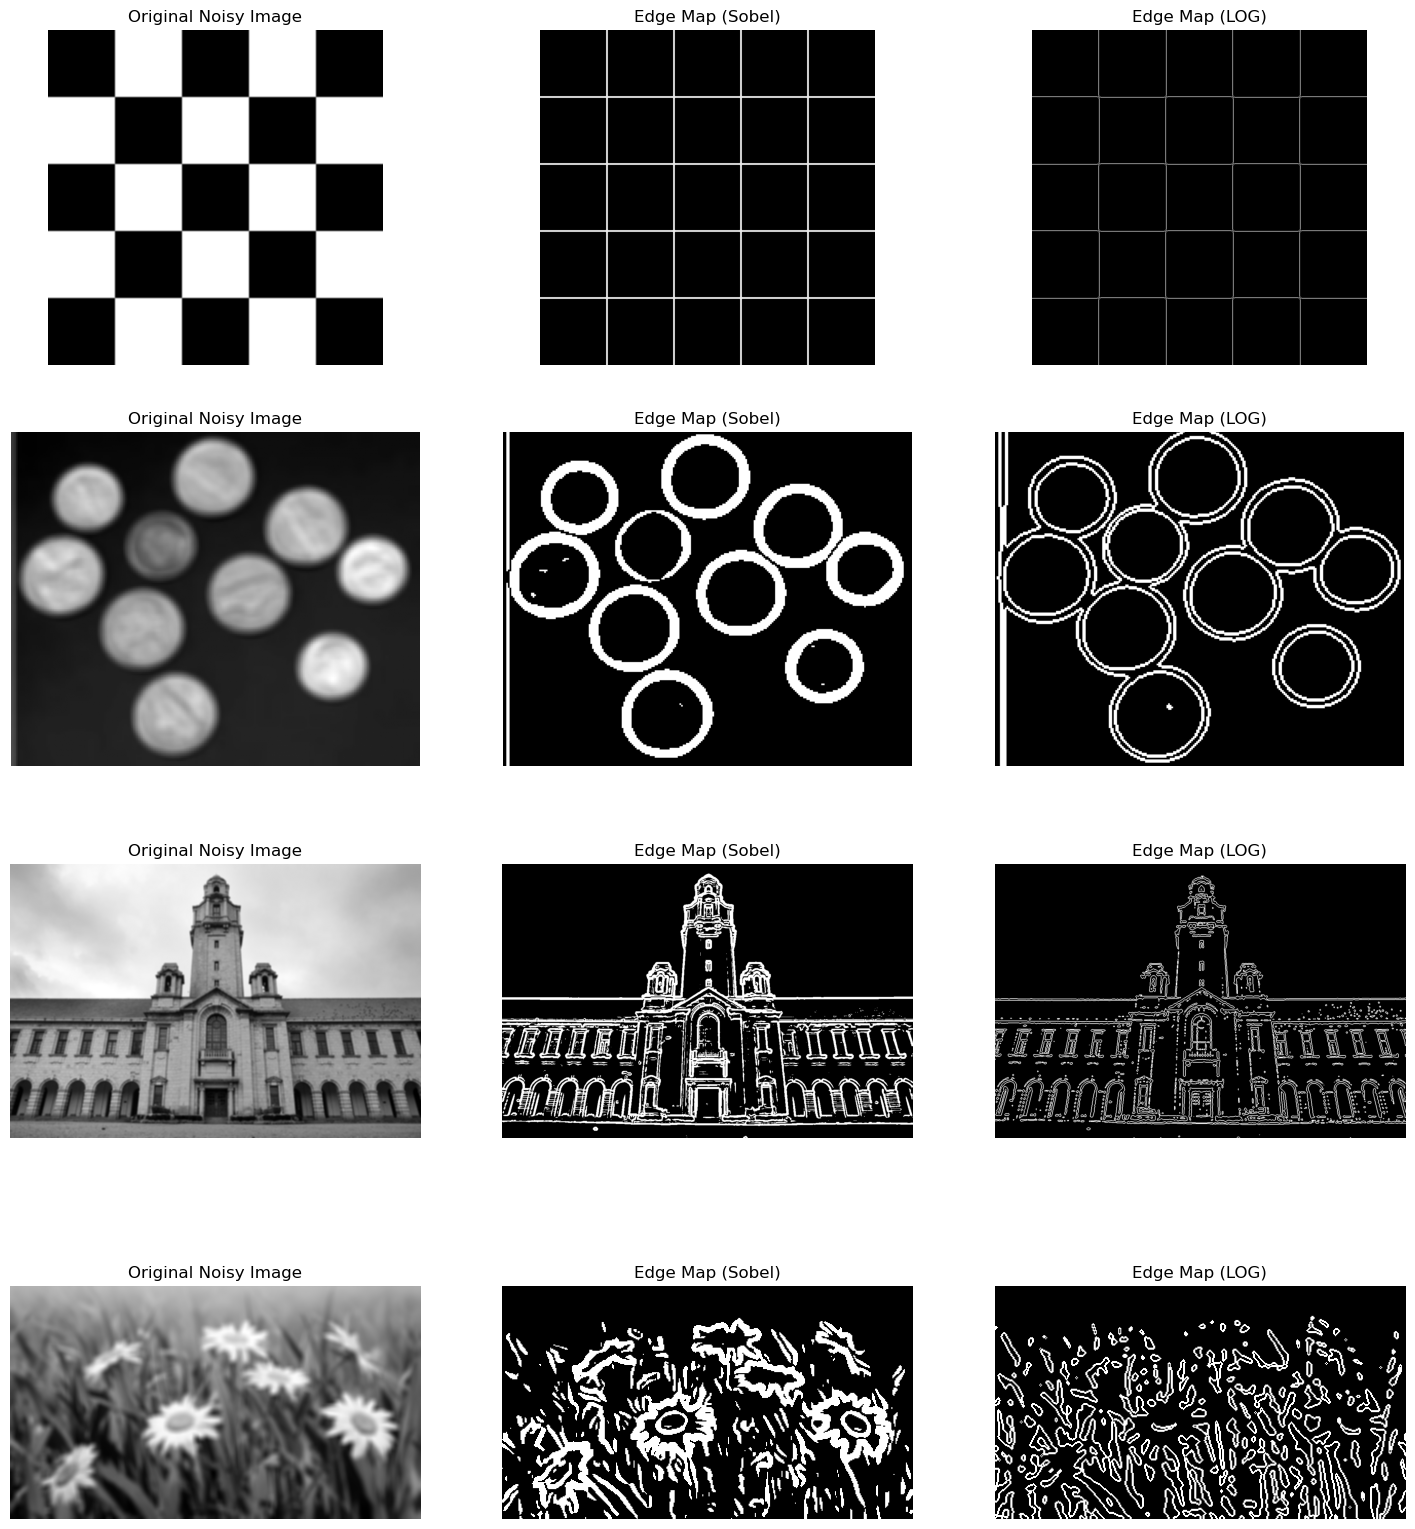

In [25]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
for i in range(len(images)):
    image = images[i]
    image = imageBlur(image, 7, 3)

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"""Original Noisy Image""")
    axes[i, 1].imshow(sobel(image), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"""Edge Map (Sobel)""")
    axes[i, 2].imshow(LOGEdgeDetector(image, 9, 1.5), cmap='gray')
    axes[i, 2].axis("off")
    axes[i, 2].set_title(f"""Edge Map (LOG)""")


## 2.c) Edge Detection Without Gaussian Smoothing But Adding Noise

Optimal Threshold for Sobel:  66
Optimal Threshold for Sobel:  137
Optimal Threshold for Sobel:  128
Optimal Threshold for Sobel:  133


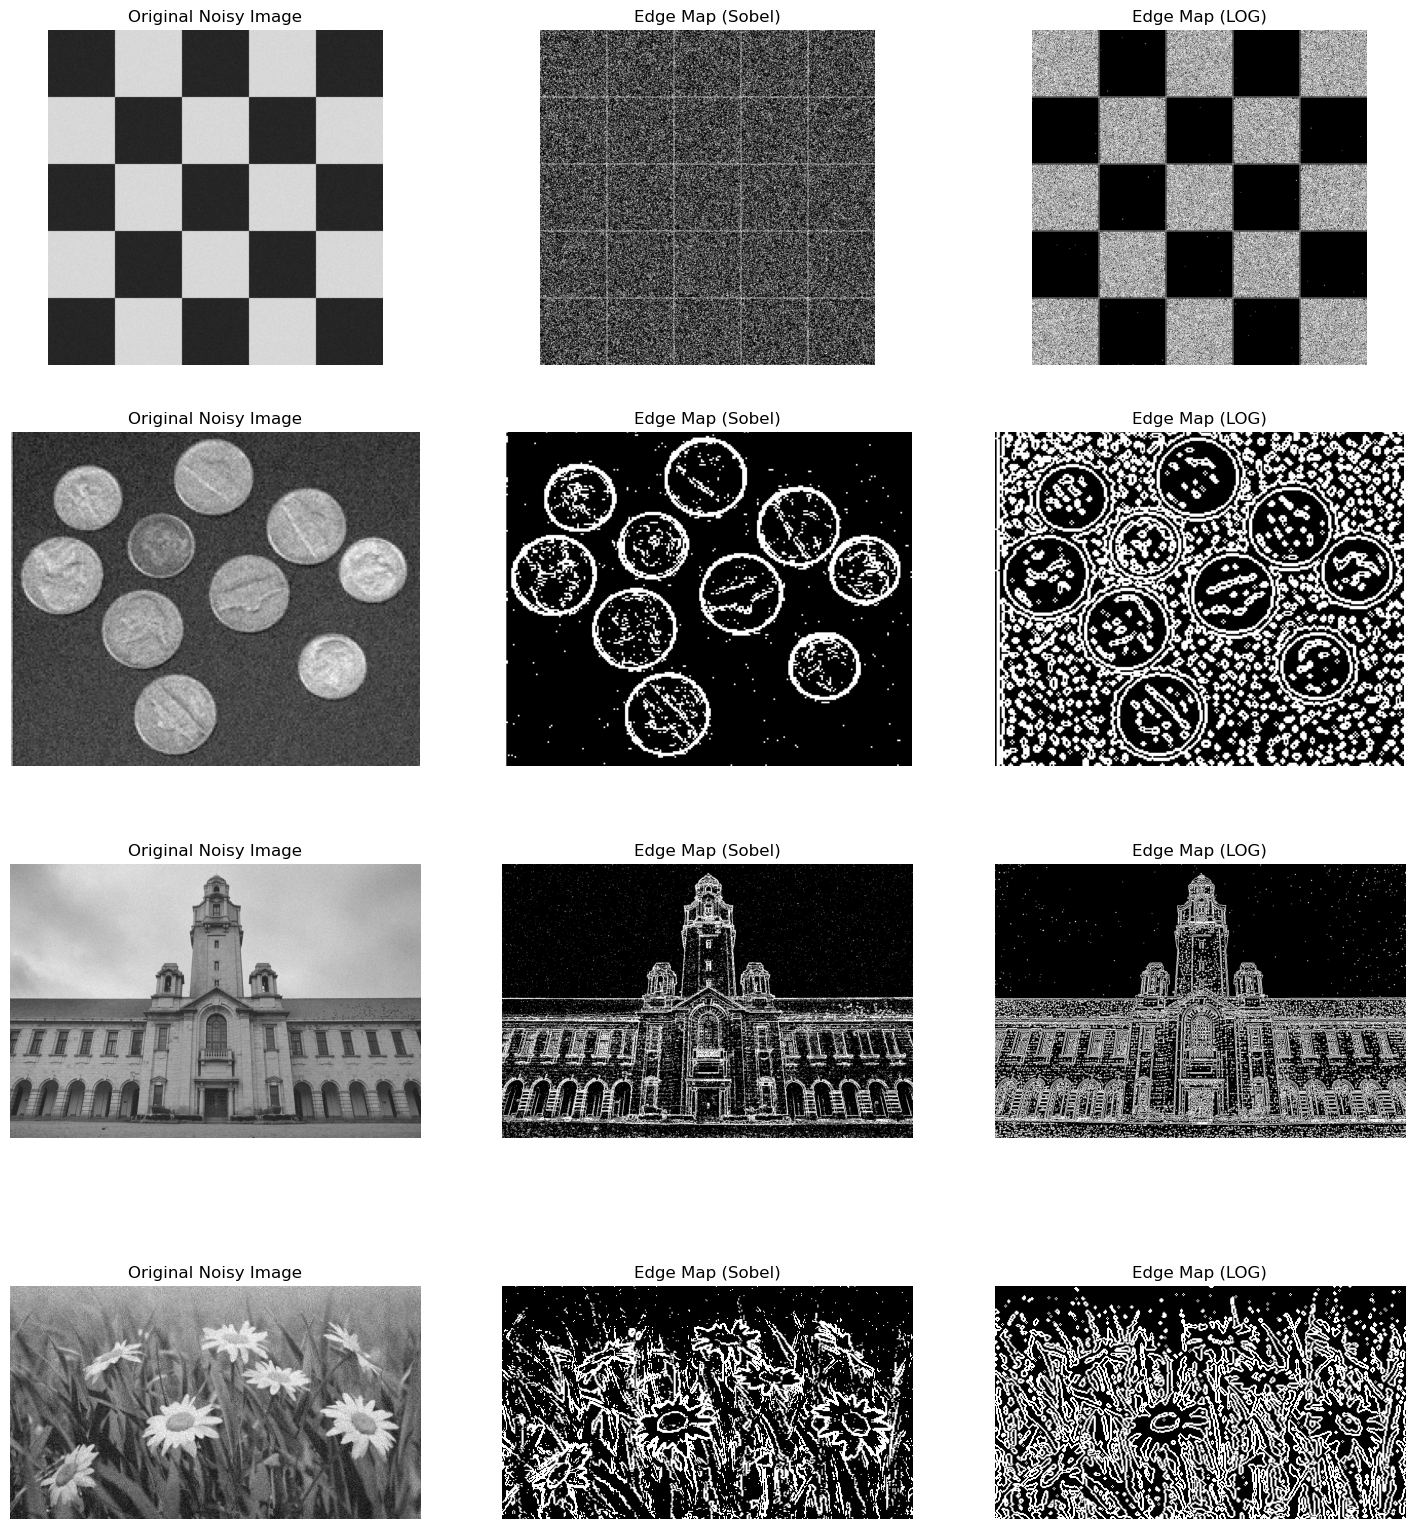

In [26]:
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
for i in range(len(images)):
    noise = np.random.normal(0, 12, images[i].shape)
    image = images[i] + noise
    
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"""Original Noisy Image""")
    axes[i, 1].imshow(sobel(image), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"""Edge Map (Sobel)""")
    axes[i, 2].imshow(LOGEdgeDetector(image, 9, 1.5), cmap='gray')
    axes[i, 2].axis("off")
    axes[i, 2].set_title(f"""Edge Map (LOG)""")
